In [554]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

import sklearn as sk
from sklearn.model_selection import TimeSeriesSplit

In [626]:
# Download the data from Yahoo Finance (^SOX and ^VIX)
start_date='2015-01-01'
end_date='2023-12-31'

data = yf.download('^SOX ^VIX', start=start_date, end=end_date, interval='1d')['Close']
data.index = pd.to_datetime(data.index)
data['^VIX^2'] = data['^VIX'].pow(2)

# Calculate the log returns
data['^SOX: Log_Returns'] = np.log(data['^SOX'].pct_change() + 1)
data['^VIX: Log_Returns'] = np.log(data['^VIX'].pct_change() + 1)
data['^VIX^2: Log_Returns'] = np.log(data['^VIX^2'].pct_change() + 1)

# Calculate the backward/forward realized volatility (Weekly RV stands for the 5-day realized volatility)
data['^SOX: Weekly_RV'] = np.sqrt((data['^SOX: Log_Returns']**2).rolling(21).sum())
data['^SOX: Next_Weekly_RV'] = np.sqrt((data['^SOX: Log_Returns']**2).rolling(21).sum()).shift(-5)
# data.head(22)
data = data.dropna()
data.describe()

[*********************100%%**********************]  2 of 2 completed


Ticker,^SOX,^VIX,^VIX^2,^SOX: Log_Returns,^VIX: Log_Returns,^VIX^2: Log_Returns,^SOX: Weekly_RV,^SOX: Next_Weekly_RV
count,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000
mean,1889.806287,18.572761,402.280955,0.000823,-0.000158,-0.000316,0.081430,0.081464
std,1036.139973,7.573580,452.738295,0.019690,0.079646,0.159292,0.038767,0.038752
min,559.179993,9.140000,83.539606,-0.173119,-0.299831,-0.599662,0.027023,0.027023
25%,1007.862488,13.370000,178.756897,-0.009083,-0.045426,-0.090852,0.056003,0.056018
50%,1478.594971,16.690001,278.556118,0.001482,-0.007285,-0.014571,0.071905,0.072046
75%,2955.530029,21.910000,480.048093,0.011404,0.035467,0.070934,0.099402,0.099402
max,4125.560059,82.690002,6837.636504,0.105753,0.768245,1.536490,0.356521,0.356521


In [627]:
data.head(10)

Ticker,^SOX,^VIX,^VIX^2,^SOX: Log_Returns,^VIX: Log_Returns,^VIX^2: Log_Returns,^SOX: Weekly_RV,^SOX: Next_Weekly_RV
Date,,,,,,,,
2015-02-03,666.929993,17.330000,300.328897,0.020894,-0.114379,-0.228758,0.063376,0.059975
2015-02-04,669.150024,18.330000,335.988897,0.003323,0.056100,0.112200,0.060451,0.056568
2015-02-05,675.690002,16.850000,283.922513,0.009726,-0.084188,-0.168377,0.057079,0.057973
2015-02-06,671.840027,17.290001,298.944132,-0.005714,0.025778,0.051555,0.056534,0.058088
2015-02-09,664.539978,18.549999,344.102472,-0.010925,0.070341,0.140683,0.049909,0.057636
2015-02-10,687.030029,17.230000,296.872884,0.033283,-0.073818,-0.147635,0.059975,0.056620
2015-02-11,689.250000,16.959999,287.641569,0.003226,-0.015794,-0.031589,0.056568,0.055778
2015-02-12,700.190002,15.340000,235.315605,0.015748,-0.100394,-0.200788,0.057973,0.054964
2015-02-13,705.080017,14.690000,215.796088,0.006960,-0.043297,-0.086594,0.058088,0.054972


In [628]:
data.tail(10)

Ticker,^SOX,^VIX,^VIX^2,^SOX: Log_Returns,^VIX: Log_Returns,^VIX^2: Log_Returns,^SOX: Weekly_RV,^SOX: Next_Weekly_RV
Date,,,,,,,,
2023-12-08,3774.169922,12.35,152.522509,0.007081,-0.055898,-0.111796,0.070138,0.063430
2023-12-11,3902.389893,12.63,159.516903,0.033409,0.022419,0.044838,0.077466,0.063429
2023-12-12,3930.179932,12.07,145.684893,0.007096,-0.045352,-0.090704,0.066966,0.063309
2023-12-13,3990.949951,12.19,148.596090,0.015344,0.009893,0.019786,0.068001,0.067968
2023-12-14,4097.470215,12.48,155.750389,0.026340,0.023511,0.047023,0.063656,0.070639
2023-12-15,4117.000000,12.28,150.798393,0.004755,-0.016155,-0.032311,0.063430,0.070648
2023-12-18,4103.790039,12.56,157.753611,-0.003214,0.022545,0.045091,0.063429,0.072874
2023-12-19,4125.560059,12.53,157.000893,0.005291,-0.002391,-0.004783,0.063309,0.072857
2023-12-20,4007.659912,13.67,186.868902,-0.028994,0.087078,0.174156,0.067968,0.072654


In [629]:
# rename the columns (delete special characters)
data = data.rename(columns=lambda x: x.replace('^', '').replace(':', ''))
data.columns

Index(['SOX', 'VIX', 'VIX2', 'SOX Log_Returns', 'VIX Log_Returns',
       'VIX2 Log_Returns', 'SOX Weekly_RV', 'SOX Next_Weekly_RV'],
      dtype='object', name='Ticker')

### Data Preprocessing
1. Wisnorization
2. Min Max Scaling

In [632]:
# Create a pipeline to transform the data (winsozation and min-max scaling)
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

scaler = MinMaxScaler()

def winsorize_data(data):
    return winsorize(np.array(data), limits=[0.05, 0.05])

def min_max_scale_data(data):
    return scaler.fit_transform(data)

def data_preprocess_transform(data):
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', FunctionTransformer(winsorize_data), data.columns),
            ('num2', FunctionTransformer(min_max_scale_data), data.columns)
        ])
    data_tmp = preprocessor.fit_transform(data)
    return pd.DataFrame(data_tmp[:, -1*len(data.columns):], columns=data.columns, index=data.index)

In [633]:
data = data_preprocess_transform(data)
data.describe()

Ticker,SOX,VIX,VIX2,SOX Log_Returns,VIX Log_Returns,VIX2 Log_Returns,SOX Weekly_RV,SOX Next_Weekly_RV
count,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000
mean,0.373103,0.128250,0.047192,0.623734,0.280573,0.280573,0.165122,0.165223
std,0.290530,0.102972,0.067032,0.070606,0.074570,0.074570,0.117654,0.117610
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.125809,0.057512,0.014098,0.588213,0.238190,0.238190,0.087951,0.087998
50%,0.257801,0.102651,0.028874,0.626099,0.273900,0.273900,0.136214,0.136643
75%,0.671928,0.173623,0.058706,0.661677,0.313927,0.313927,0.219663,0.219663
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Training and Testing Dataset Preparation
1. Training Data : 2015-2022
2. Testing Data: 2023

In [634]:
# Split the data into training and test sets (training data from 2015 to 2020, test data from 2021 to 2022)
data_train = data.loc['2015-01-01':'2022-12-31']
data_test = data.loc['2023-01-01':'2023-12-31']

### Base Model Attributes(X) and Target(Y)
1. X \
    1.1 Index Value: ^SOX, ^VIX \
    1.2 Square Value: ^VIX^2 \
    1.3 Log Return: ^SOX, ^VIX, ^VIX^2
    
2. y: Weekly Relative Volatility of ^SOX

In [635]:
# Split the data into features and target
X_base_train = data_train.drop(columns=['SOX Next_Weekly_RV'])
y_train = data_train[['SOX Next_Weekly_RV']]
X_base_test = data_test.drop(columns=['SOX Next_Weekly_RV'])
y_test = data_test[['SOX Next_Weekly_RV']]

### Benchmark Model Training and Performance
1. Decesion Tree Regressor
2. Linear Regression

performance matrix
1. Root Mean Square Error
2. R-square

In [636]:
# Create a decision tree regressor model and use parameters from the grid search
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

model = DecisionTreeRegressor(random_state=42)
model.fit(X_base_train, y_train)

param_grid = {
    'max_depth': range(1, 5),
    'min_samples_split': range(2, 5),
    'min_samples_leaf': range(3, 8),
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=2, n_jobs=-1, verbose=-1)
grid_search.fit(X_base_train, y_train)

# Report the best model parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")

Best parameters: {'max_depth': 4, 'min_samples_leaf': 6, 'min_samples_split': 2}
Best score: 0.5080306300686599


In [637]:
# Predict the target variable for the test set and calculate the RMSE and R2 score
from sklearn.metrics import mean_squared_error, r2_score

model = grid_search.best_estimator_
y_pred = model.predict(X_base_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R2 score: {r2}")

RMSE: 0.034765554012775104
R2 score: 0.5198468664528884


In [638]:
# Create a linear regression model
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_base_train, y_train)

LinearRegression()

In [639]:
# Predict the target variable for the test set and calculate the RMSE and R2 score
y_pred = model.predict(X_base_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R2 score: {r2}")

RMSE: 0.029291903495892665
R2 score: 0.6591395227928585


### LightGBM Model Training and Performance
Hyperparamter tuning: Optuna

Time series split = 5

Objective function: Mean(Root Mean Squared Error)

Performance matrix:
1. Root Mean Squared Error
2. R-square
3. Root Mean Squared Percentage Error

Reference:\
https://forecastegy.com/posts/how-to-use-optuna-to-tune-lightgbm-hyperparameters/

In [640]:
# Clear the model result
model_result = model_result.iloc[0:0]

In [641]:
model_result = pd.DataFrame(columns=['Name', 'Stydy', 'Model', 'RMSE', 'R2', 'RMSPE'])

In [642]:
tscv = TimeSeriesSplit(n_splits=5)

In [643]:
import lightgbm as lgb
import optuna

def objective(trial, X, y):
    params = {
        "objective": "regression",
        "metric": "rmse",
        "n_estimators": 200,
        "verbosity": -1,
        "bagging_freq": 1,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**4),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 20),
        "gamma": trial.suggest_int("gamma", 5, 20),
    }

    rmse_scores = np.array([])
    model = lgb.LGBMRegressor(**params)

    for train_index, val_index in tscv.split(X):
        # print("TRAIN:", train_index, "TEST:", val_index)
        X_t, X_val = X.iloc[train_index], X.iloc[val_index]
        y_t, y_val = y.iloc[train_index], y.iloc[val_index]
        model.fit(X_t, y_t)
        predictions = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, predictions))
        rmse_scores = np.append(rmse_scores, rmse)
    return rmse_scores.mean()

In [644]:
def lightgbm_train_performance(model_name, bool_new_data, new_features_data):
    # Split the data into training and test sets (training data from 2015 to 2020, test data from 2021 to 2022)
    if bool_new_data:
        data_train = pd.concat([data, new_features_data], axis=1).loc['2015-01-01':'2022-12-31'].dropna()
        data_test = pd.concat([data, new_features_data], axis=1).loc['2023-01-01':'2023-12-31'].dropna()
    else:
        data_train = data.loc['2015-01-01':'2022-12-31'].dropna()
        data_test = data.loc['2023-01-01':'2023-12-31'].dropna()

    # Create X and y
    X_train = data_train.drop(columns=['SOX Next_Weekly_RV'])
    y_train = data_train[['SOX Next_Weekly_RV']]
    X_test = data_test.drop(columns=['SOX Next_Weekly_RV'])
    y_test = data_test[['SOX Next_Weekly_RV']]
    
    sampler = optuna.samplers.TPESampler(seed=10)
    study = optuna.create_study(sampler=sampler, direction='minimize')
    study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=30)
    
    # Create a LightGBM model with the best parameters
    best_params = study.best_params
    model = lgb.LGBMRegressor(**best_params)
    model.fit(X_train, y_train)

    # Predict the target variable for the test set and calculate the RMSE, R2 score and RMSPE
    y_pred = model.predict(X_train)
    # plot the prediction and the actual values for training set
    plt.figure(figsize=(15, 6))
    plt.plot(y_train.index, y_train, label='Target Volatility')
    plt.plot(y_train.index, y_pred, label='Forecast Volatility')
    plt.title('LightGBM_' + model_name +' Training Set')
    plt.legend()
    plt.show()

    # Predict the target variable for the test set and calculate the RMSE, R2 score and RMSPE
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    rmspe = np.sqrt(np.mean(np.square((y_test.squeeze() - y_pred.squeeze()) / y_test.squeeze())))

    # print(f"RMSE: {rmse}")
    # print(f"R2 score: {r2}")

    # plot the prediction and the actual values
    plt.figure(figsize=(15, 6))
    plt.plot(y_test.index, y_test, label='Target Volatility')
    plt.plot(y_test.index, y_pred, label='Forecast Volatility')
    plt.title('LightGBM_' + model_name +' Testing Set')
    plt.legend()
    plt.show()

    model_result.loc[len(model_result)] = ['LightGBM_'+model_name, study, model, rmse, r2, rmspe]    

[I 2024-04-28 12:50:10,313] A new study created in memory with name: no-name-821f90f1-5cbe-42f3-b6ff-8c49fec3f8ad
[I 2024-04-28 12:50:10,412] Trial 0 finished with value: 0.06780257527691516 and parameters: {'learning_rate': 0.034885205571560766, 'num_leaves': 2, 'subsample': 0.8168241174631377, 'colsample_bytree': 0.8744019412693059, 'min_data_in_leaf': 10, 'gamma': 8}. Best is trial 0 with value: 0.06780257527691516.
[I 2024-04-28 12:50:10,678] Trial 1 finished with value: 0.1016359015107006 and parameters: {'learning_rate': 0.002489577954043502, 'num_leaves': 13, 'subsample': 0.5845554182812678, 'colsample_bytree': 0.5441699070870052, 'min_data_in_leaf': 14, 'gamma': 20}. Best is trial 0 with value: 0.06780257527691516.
[I 2024-04-28 12:50:10,873] Trial 2 finished with value: 0.11070810288309538 and parameters: {'learning_rate': 0.001018348745338606, 'num_leaves': 9, 'subsample': 0.9063104808260567, 'colsample_bytree': 0.8062630334146941, 'min_data_in_leaf': 15, 'gamma': 9}. Best is

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 1993, number of used features: 7
[LightGBM] [Info] Start training from score 0.165203
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


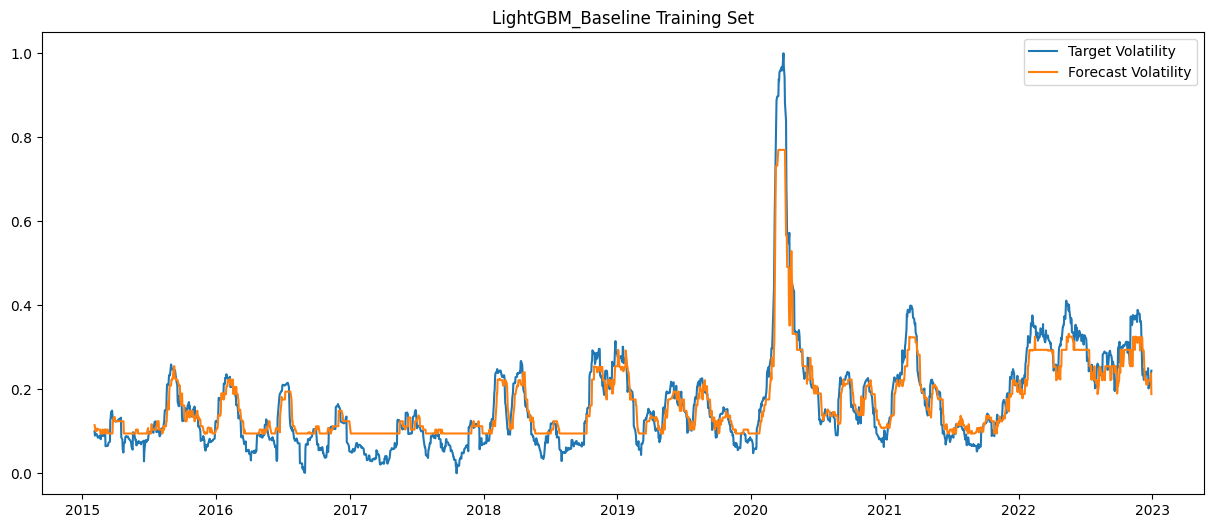

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


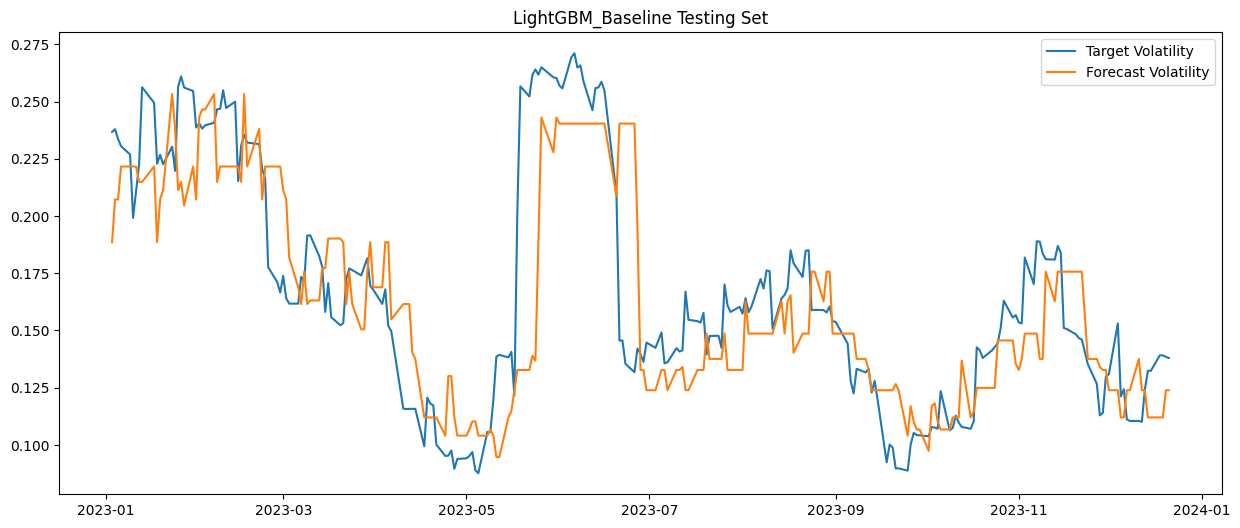

In [645]:
lightgbm_train_performance('Baseline', False, None)

### Feature Engineering
Y Lagged
1. lag weekly realized volatility
2. log of lag weekly realized volatility
3. square of lag weekly realized volatility

Non Linear VIX
1. log of VIX
2. log of past x days VIX

SOX Spread
1. SOX High-Low Spread
2. SOX Open-Close Spread

Technical Analysis
1. Bollinger Bands of SOX
2. Average True Range of SOX

In [646]:
# Replace the values of 'SOX Weekly_RV' less than 0.0001 with 0.0001 to prevent the log transformation from returning -inf
data.loc[data['SOX Weekly_RV'] <= 0.0001, 'SOX Weekly_RV'] = 0.0001

data_lag = pd.DataFrame()
for i in range(0, 15):
    # Add new columns name 'SOX Weekly_RV Lag' (14 periods lag)
    data_lag[f'SOX Weekly_RV Lag {i}'] = data['SOX Weekly_RV'].shift(i)
    # Add new columns name 'SOX Weekly_Log_RV Lag' (14 periods lag)
    data_lag[f'SOX Weekly_Log_RV Lag {i}'] = np.log(data['SOX Weekly_RV']).shift(i)
    # Add new columns name 'SOX Weekly_Squared_RV Lag' (14 periods lag)
    data_lag[f'SOX Weekly_Squared_RV Lag {i}'] = (data['SOX Weekly_RV']**2).shift(i)

data_lag = data_preprocess_transform(data_lag.dropna())
data_lag

,SOX Weekly_RV Lag 0,SOX Weekly_Log_RV Lag 0,SOX Weekly_Squared_RV Lag 0,SOX Weekly_RV Lag 1,SOX Weekly_Log_RV Lag 1,SOX Weekly_Squared_RV Lag 1,SOX Weekly_RV Lag 2,SOX Weekly_Log_RV Lag 2,SOX Weekly_Squared_RV Lag 2,SOX Weekly_RV Lag 3,...,SOX Weekly_Squared_RV Lag 11,SOX Weekly_RV Lag 12,SOX Weekly_Log_RV Lag 12,SOX Weekly_Squared_RV Lag 12,SOX Weekly_RV Lag 13,SOX Weekly_Log_RV Lag 13,SOX Weekly_Squared_RV Lag 13,SOX Weekly_RV Lag 14,SOX Weekly_Log_RV Lag 14,SOX Weekly_Squared_RV Lag 14
Date,,,,,,,,,,,,,,,,,,,,,
2015-02-24,0.089286,0.737807,0.007988,0.084732,0.732129,0.007195,0.084708,0.732098,0.007191,0.087177,...,0.008021,0.091127,0.740020,0.008321,0.101361,0.751564,0.010292,0.110240,0.760672,0.012172
2015-02-25,0.089986,0.738653,0.008114,0.089286,0.737807,0.007988,0.084732,0.732129,0.007195,0.084708,...,0.004824,0.089471,0.738032,0.008021,0.091127,0.740020,0.008321,0.101361,0.751564,0.010292
2015-02-26,0.081636,0.728092,0.006679,0.089986,0.738653,0.008114,0.089286,0.737807,0.007988,0.084732,...,0.010001,0.069363,0.710428,0.004824,0.089471,0.738032,0.008021,0.091127,0.740020,0.008321
2015-02-27,0.080986,0.727226,0.006574,0.081636,0.728092,0.006679,0.089986,0.738653,0.008114,0.089286,...,0.008040,0.099917,0.750008,0.010001,0.069363,0.710428,0.004824,0.089471,0.738032,0.008021
2015-03-02,0.100962,0.751136,0.010211,0.080986,0.727226,0.006574,0.081636,0.728092,0.006679,0.089986,...,0.008823,0.089575,0.738157,0.008040,0.099917,0.750008,0.010001,0.069363,0.710428,0.004824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-15,0.110402,0.760832,0.012208,0.111090,0.761505,0.012361,0.124276,0.773673,0.015466,0.121136,...,0.021325,0.146606,0.791601,0.021518,0.148272,0.792827,0.022010,0.150535,0.794471,0.022686
2023-12-18,0.110399,0.760829,0.012208,0.110402,0.760832,0.012208,0.111090,0.761505,0.012361,0.124276,...,0.018306,0.145944,0.791110,0.021325,0.146606,0.791601,0.021518,0.148272,0.792827,0.022010
2023-12-19,0.110036,0.760471,0.012127,0.110399,0.760829,0.012208,0.110402,0.760832,0.012208,0.111090,...,0.016054,0.135212,0.782823,0.018306,0.145944,0.791110,0.021325,0.146606,0.791601,0.021518


[I 2024-04-28 12:50:16,294] A new study created in memory with name: no-name-0f12a2f9-696b-47b0-908f-f1b78f01f993


[I 2024-04-28 12:50:16,524] Trial 0 finished with value: 0.06953191396157314 and parameters: {'learning_rate': 0.034885205571560766, 'num_leaves': 2, 'subsample': 0.8168241174631377, 'colsample_bytree': 0.8744019412693059, 'min_data_in_leaf': 10, 'gamma': 8}. Best is trial 0 with value: 0.06953191396157314.
[I 2024-04-28 12:50:17,246] Trial 1 finished with value: 0.09713659035866276 and parameters: {'learning_rate': 0.002489577954043502, 'num_leaves': 13, 'subsample': 0.5845554182812678, 'colsample_bytree': 0.5441699070870052, 'min_data_in_leaf': 14, 'gamma': 20}. Best is trial 0 with value: 0.06953191396157314.
[I 2024-04-28 12:50:17,982] Trial 2 finished with value: 0.11094133203882199 and parameters: {'learning_rate': 0.001018348745338606, 'num_leaves': 9, 'subsample': 0.9063104808260567, 'colsample_bytree': 0.8062630334146941, 'min_data_in_leaf': 15, 'gamma': 9}. Best is trial 0 with value: 0.06953191396157314.
[I 2024-04-28 12:50:18,677] Trial 3 finished with value: 0.073209860828

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13260
[LightGBM] [Info] Number of data points in the train set: 1979, number of used features: 52
[LightGBM] [Info] Start training from score 0.165735
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17


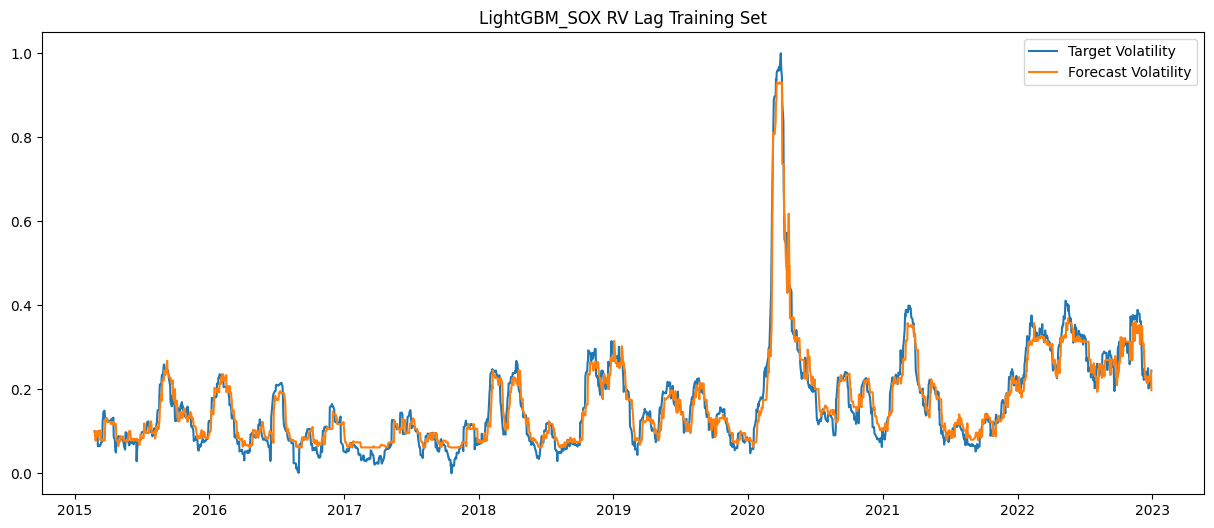

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17


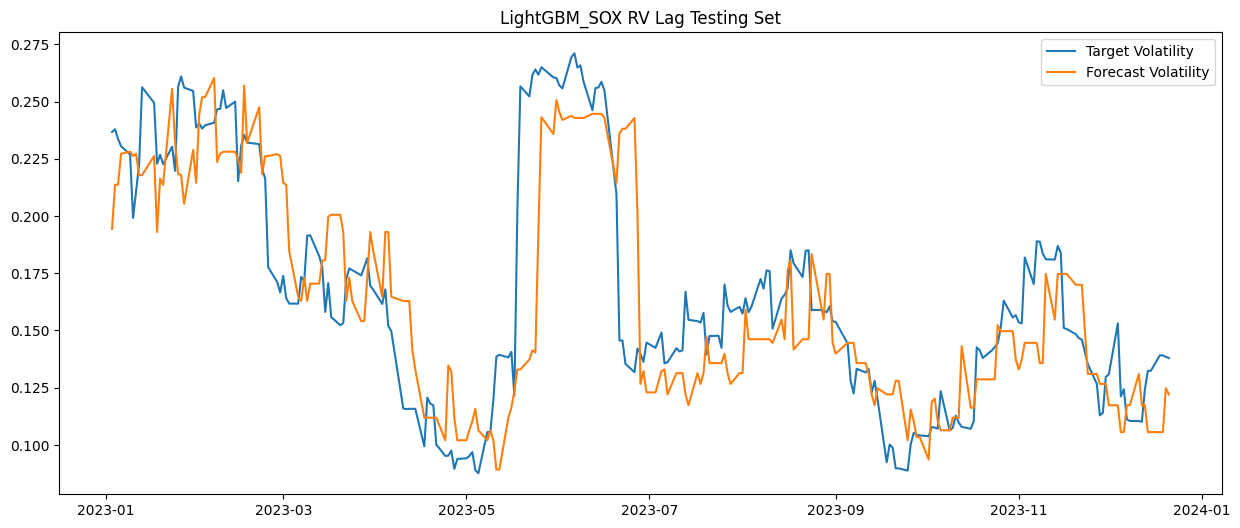

In [647]:
lightgbm_train_performance('SOX RV Lag', True, data_lag)

In [648]:
# Replace the values of 'SOX Weekly_RV' less than 0.0001 with 0.0001 to prevent the log transformation from returning -inf
data.loc[data['VIX'] <= 0.0001, 'VIX'] = 0.0001

# Create new dataframe to store new features for Lof of VIX and Log of past x-day VIX
data_VIX = pd.DataFrame()
data_VIX['VIX Log'] = np.log(data['VIX'])
for i in range(1, 21, 5):
    data_VIX[f'VIX Log {i} Day Mean'] = np.log(data['VIX'].rolling(i).mean())
    data_VIX[f'VIX Log {i} Day Sum'] = np.log(data['VIX'].rolling(i).sum())

data_VIX = data_preprocess_transform(data_VIX.dropna())

[I 2024-04-28 12:50:32,623] A new study created in memory with name: no-name-46ff274c-13d0-409d-a43b-e053977fd508


[I 2024-04-28 12:50:33,030] Trial 0 finished with value: 0.07023612865039583 and parameters: {'learning_rate': 0.034885205571560766, 'num_leaves': 2, 'subsample': 0.8168241174631377, 'colsample_bytree': 0.8744019412693059, 'min_data_in_leaf': 10, 'gamma': 8}. Best is trial 0 with value: 0.07023612865039583.
[I 2024-04-28 12:50:33,483] Trial 1 finished with value: 0.1010650841413832 and parameters: {'learning_rate': 0.002489577954043502, 'num_leaves': 13, 'subsample': 0.5845554182812678, 'colsample_bytree': 0.5441699070870052, 'min_data_in_leaf': 14, 'gamma': 20}. Best is trial 0 with value: 0.07023612865039583.
[I 2024-04-28 12:50:33,857] Trial 2 finished with value: 0.11129199343393012 and parameters: {'learning_rate': 0.001018348745338606, 'num_leaves': 9, 'subsample': 0.9063104808260567, 'colsample_bytree': 0.8062630334146941, 'min_data_in_leaf': 15, 'gamma': 9}. Best is trial 0 with value: 0.07023612865039583.
[I 2024-04-28 12:50:34,232] Trial 3 finished with value: 0.0802073581167

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 1978, number of used features: 16
[LightGBM] [Info] Start training from score 0.165768
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


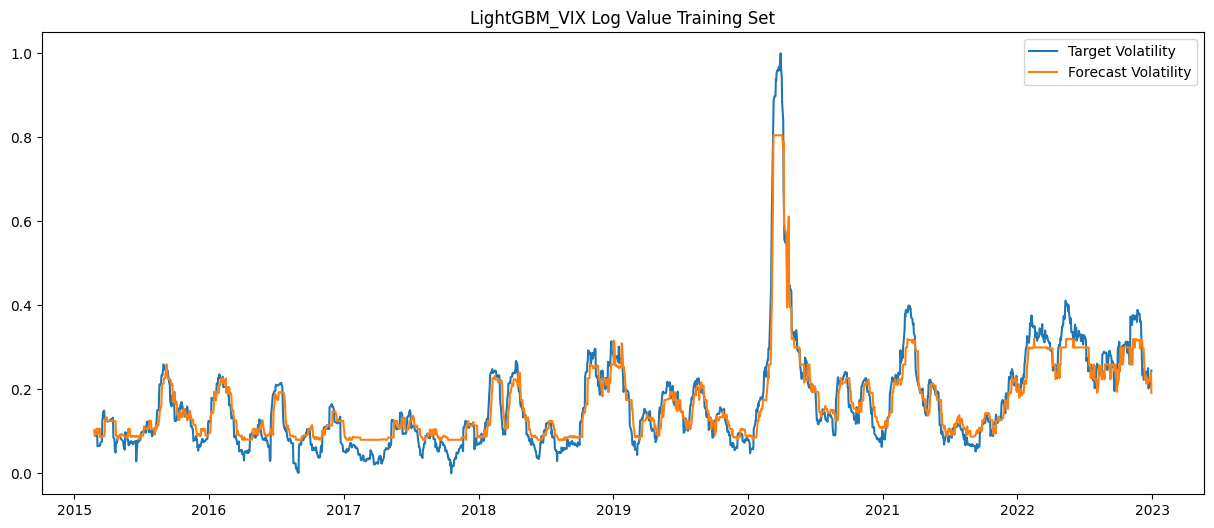

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


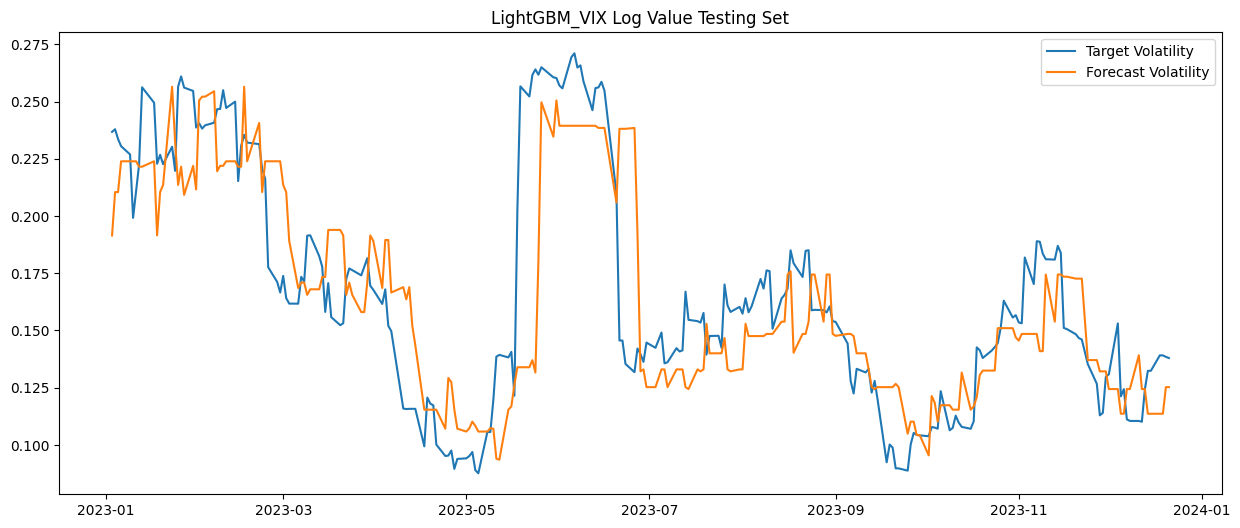

In [649]:
lightgbm_train_performance('VIX Log Value', True, data_VIX)

In [650]:
# Download the ^SOX data from Yahoo Finance (Open, High, Low, Close)
data_spread = yf.download('^SOX', start=start_date, end=end_date, interval='1d')[['Open', 'High', 'Low', 'Close']]
data_spread.index = pd.to_datetime(data_spread.index)

# Calculate the spread between the High and Low prices, open and close prices
data_spread['Spread'] = data_spread['High'] - data_spread['Low']
data_spread['Open_Close_Diff'] = data_spread['Open'] - data_spread['Close']

data_spread

[*********************100%%**********************]  1 of 1 completed
C:\Users\LiaoYF\AppData\Local\Temp\ipykernel_22220\3536122909.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_spread['Spread'] = data_spread['High'] - data_spread['Low']


,Open,High,Low,Close,Spread,Open_Close_Diff
Date,,,,,,
2015-01-02,690.280029,694.030029,680.280029,686.729980,13.750000,3.550049
2015-01-05,683.570007,684.840027,673.429993,673.590027,11.410034,9.979980
2015-01-06,675.119995,675.140015,656.369995,658.830017,18.770020,16.289978
2015-01-07,660.419983,668.219971,658.750000,665.270020,9.469971,-4.850037
2015-01-08,671.809998,686.200012,671.809998,684.650024,14.390015,-12.840027
...,...,...,...,...,...,...
2023-12-22,4134.580078,4153.250000,4104.689941,4132.850098,48.560059,1.729980
2023-12-26,4155.729980,4222.319824,4155.200195,4207.450195,67.119629,-51.720215
2023-12-27,4222.240234,4230.930176,4194.959961,4214.589844,35.970215,7.650391


In [651]:
# Add new columns of lag spread and lag open-close difference (14 periods lag)
data_spread_lag = pd.DataFrame()
for i in range(0, 15):
    data_spread_lag[f'Spread Lag {i}'] = data_spread['Spread'].shift(i)
    data_spread_lag[f'Open_Close_Diff Lag {i}'] = data_spread['Open_Close_Diff'].shift(i)

data_spread_lag = data_preprocess_transform(data_spread_lag)
data_spread_lag

,Spread Lag 0,Open_Close_Diff Lag 0,Spread Lag 1,Open_Close_Diff Lag 1,Spread Lag 2,Open_Close_Diff Lag 2,Spread Lag 3,Open_Close_Diff Lag 3,Spread Lag 4,Open_Close_Diff Lag 4,...,Spread Lag 10,Open_Close_Diff Lag 10,Spread Lag 11,Open_Close_Diff Lag 11,Spread Lag 12,Open_Close_Diff Lag 12,Spread Lag 13,Open_Close_Diff Lag 13,Spread Lag 14,Open_Close_Diff Lag 14
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,0.054665,0.561924,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,0.045363,0.576620,0.054665,0.561924,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-06,0.074623,0.591041,0.045363,0.576620,0.054665,0.561924,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-07,0.037649,0.542726,0.074623,0.591041,0.045363,0.576620,0.054665,0.561924,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-08,0.057210,0.524466,0.037649,0.542726,0.074623,0.591041,0.045363,0.576620,0.054665,0.561924,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,0.193059,0.557765,0.201446,0.498275,0.440901,0.750908,0.115890,0.499348,0.210075,0.577396,...,0.202958,0.487190,0.347673,0.386835,0.339363,0.737492,0.153342,0.519826,0.250308,0.567958
2023-12-26,0.266845,0.435607,0.193059,0.557765,0.201446,0.498275,0.440901,0.750908,0.115890,0.499348,...,0.429889,0.348463,0.202958,0.487190,0.347673,0.386835,0.339363,0.737492,0.153342,0.519826
2023-12-27,0.143006,0.571295,0.266845,0.435607,0.193059,0.557765,0.201446,0.498275,0.440901,0.750908,...,0.199578,0.444863,0.429889,0.348463,0.202958,0.487190,0.347673,0.386835,0.339363,0.737492


[I 2024-04-28 12:50:43,221] A new study created in memory with name: no-name-a7cc571c-2481-457b-9508-991fa77cf9bc


[I 2024-04-28 12:50:43,408] Trial 0 finished with value: 0.07070462856930214 and parameters: {'learning_rate': 0.034885205571560766, 'num_leaves': 2, 'subsample': 0.8168241174631377, 'colsample_bytree': 0.8744019412693059, 'min_data_in_leaf': 10, 'gamma': 8}. Best is trial 0 with value: 0.07070462856930214.
[I 2024-04-28 12:50:43,955] Trial 1 finished with value: 0.09744257103700331 and parameters: {'learning_rate': 0.002489577954043502, 'num_leaves': 13, 'subsample': 0.5845554182812678, 'colsample_bytree': 0.5441699070870052, 'min_data_in_leaf': 14, 'gamma': 20}. Best is trial 0 with value: 0.07070462856930214.
[I 2024-04-28 12:50:44,525] Trial 2 finished with value: 0.11024352338585289 and parameters: {'learning_rate': 0.001018348745338606, 'num_leaves': 9, 'subsample': 0.9063104808260567, 'colsample_bytree': 0.8062630334146941, 'min_data_in_leaf': 15, 'gamma': 9}. Best is trial 0 with value: 0.07070462856930214.
[I 2024-04-28 12:50:45,105] Trial 3 finished with value: 0.083007769901

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9435
[LightGBM] [Info] Number of data points in the train set: 1993, number of used features: 37
[LightGBM] [Info] Start training from score 0.165203
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6


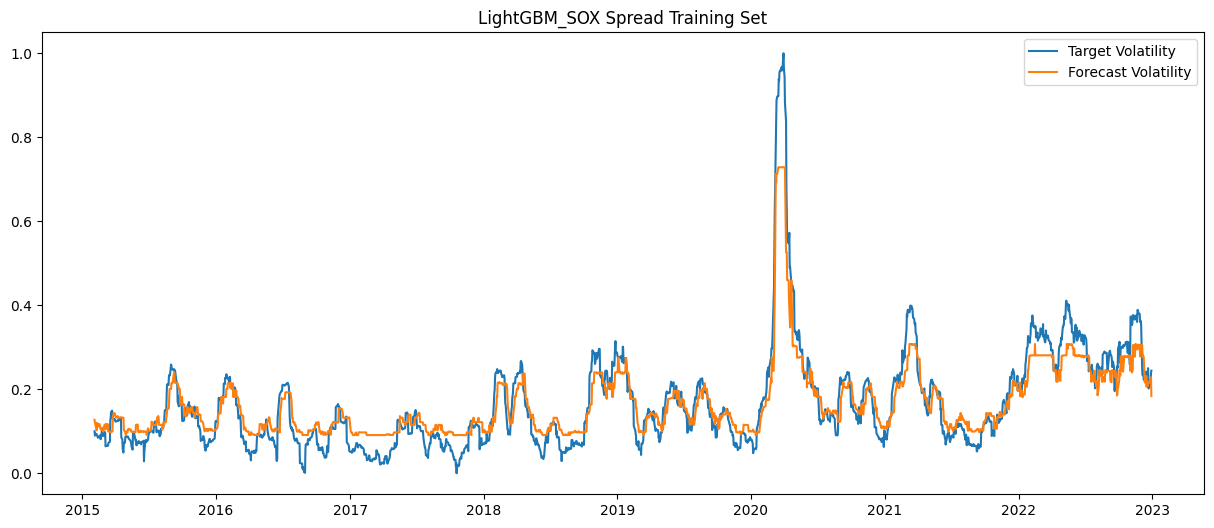

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6


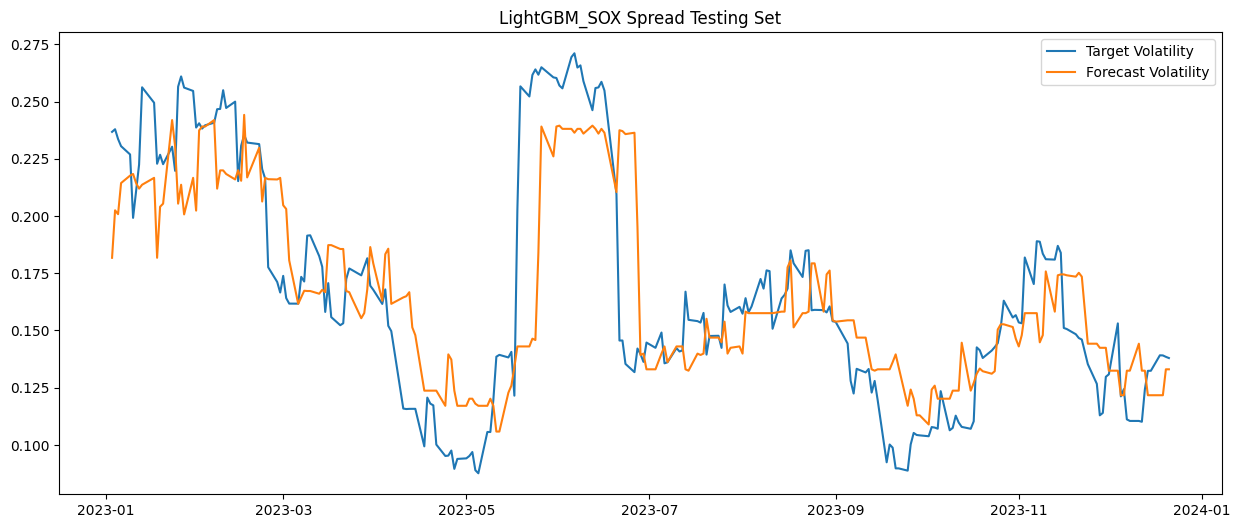

In [652]:
lightgbm_train_performance('SOX Spread', True, data_spread_lag)

              BB_High_5     BB_Low_5      ATR_5   BB_High_10    BB_Low_10  \
Date                                                                        
2015-01-02          NaN          NaN   0.000000          NaN          NaN   
2015-01-05          NaN          NaN   0.000000          NaN          NaN   
2015-01-06          NaN          NaN   0.000000          NaN          NaN   
2015-01-07          NaN          NaN   0.000000          NaN          NaN   
2015-01-08   697.934782   649.693245  15.243994          NaN          NaN   
...                 ...          ...        ...          ...          ...   
2023-12-22  4200.609392  3994.770588  79.006689  4226.833028  3878.454960   
2023-12-26  4261.437439  3975.406604  81.099296  4246.927082  3919.372967   
2023-12-27  4303.755432  3968.700525  72.073480  4254.791353  3968.390678   
2023-12-28  4269.722929  4083.141134  63.268745  4260.329739  4006.398337   
2023-12-29  4256.447181  4119.169030  62.695074  4267.912809  4014.415267   

C:\Users\LiaoYF\AppData\Local\Temp\ipykernel_22220\3337219470.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha='right', fontsize=6)
C:\Users\LiaoYF\AppData\Local\Temp\ipykernel_22220\3337219470.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha='right', fontsize=6)
C:\Users\LiaoYF\AppData\Local\Temp\ipykernel_22220\3337219470.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha='right', fontsize=6)


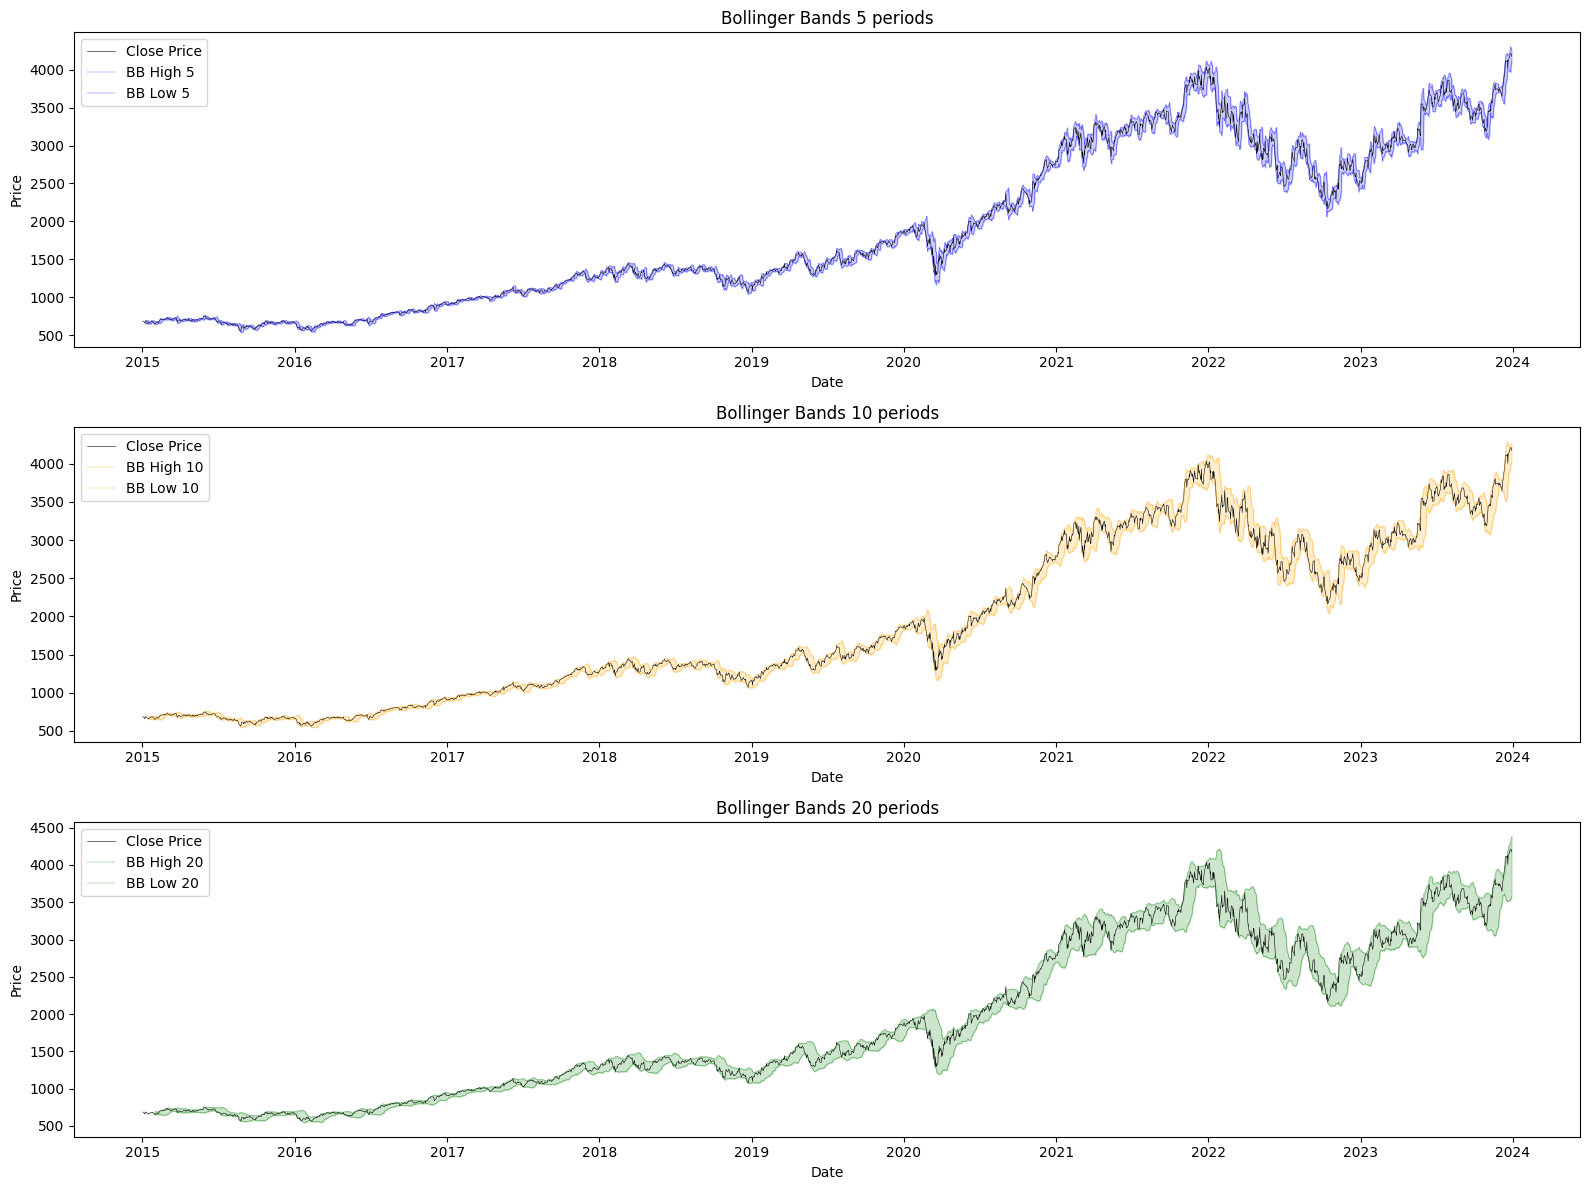

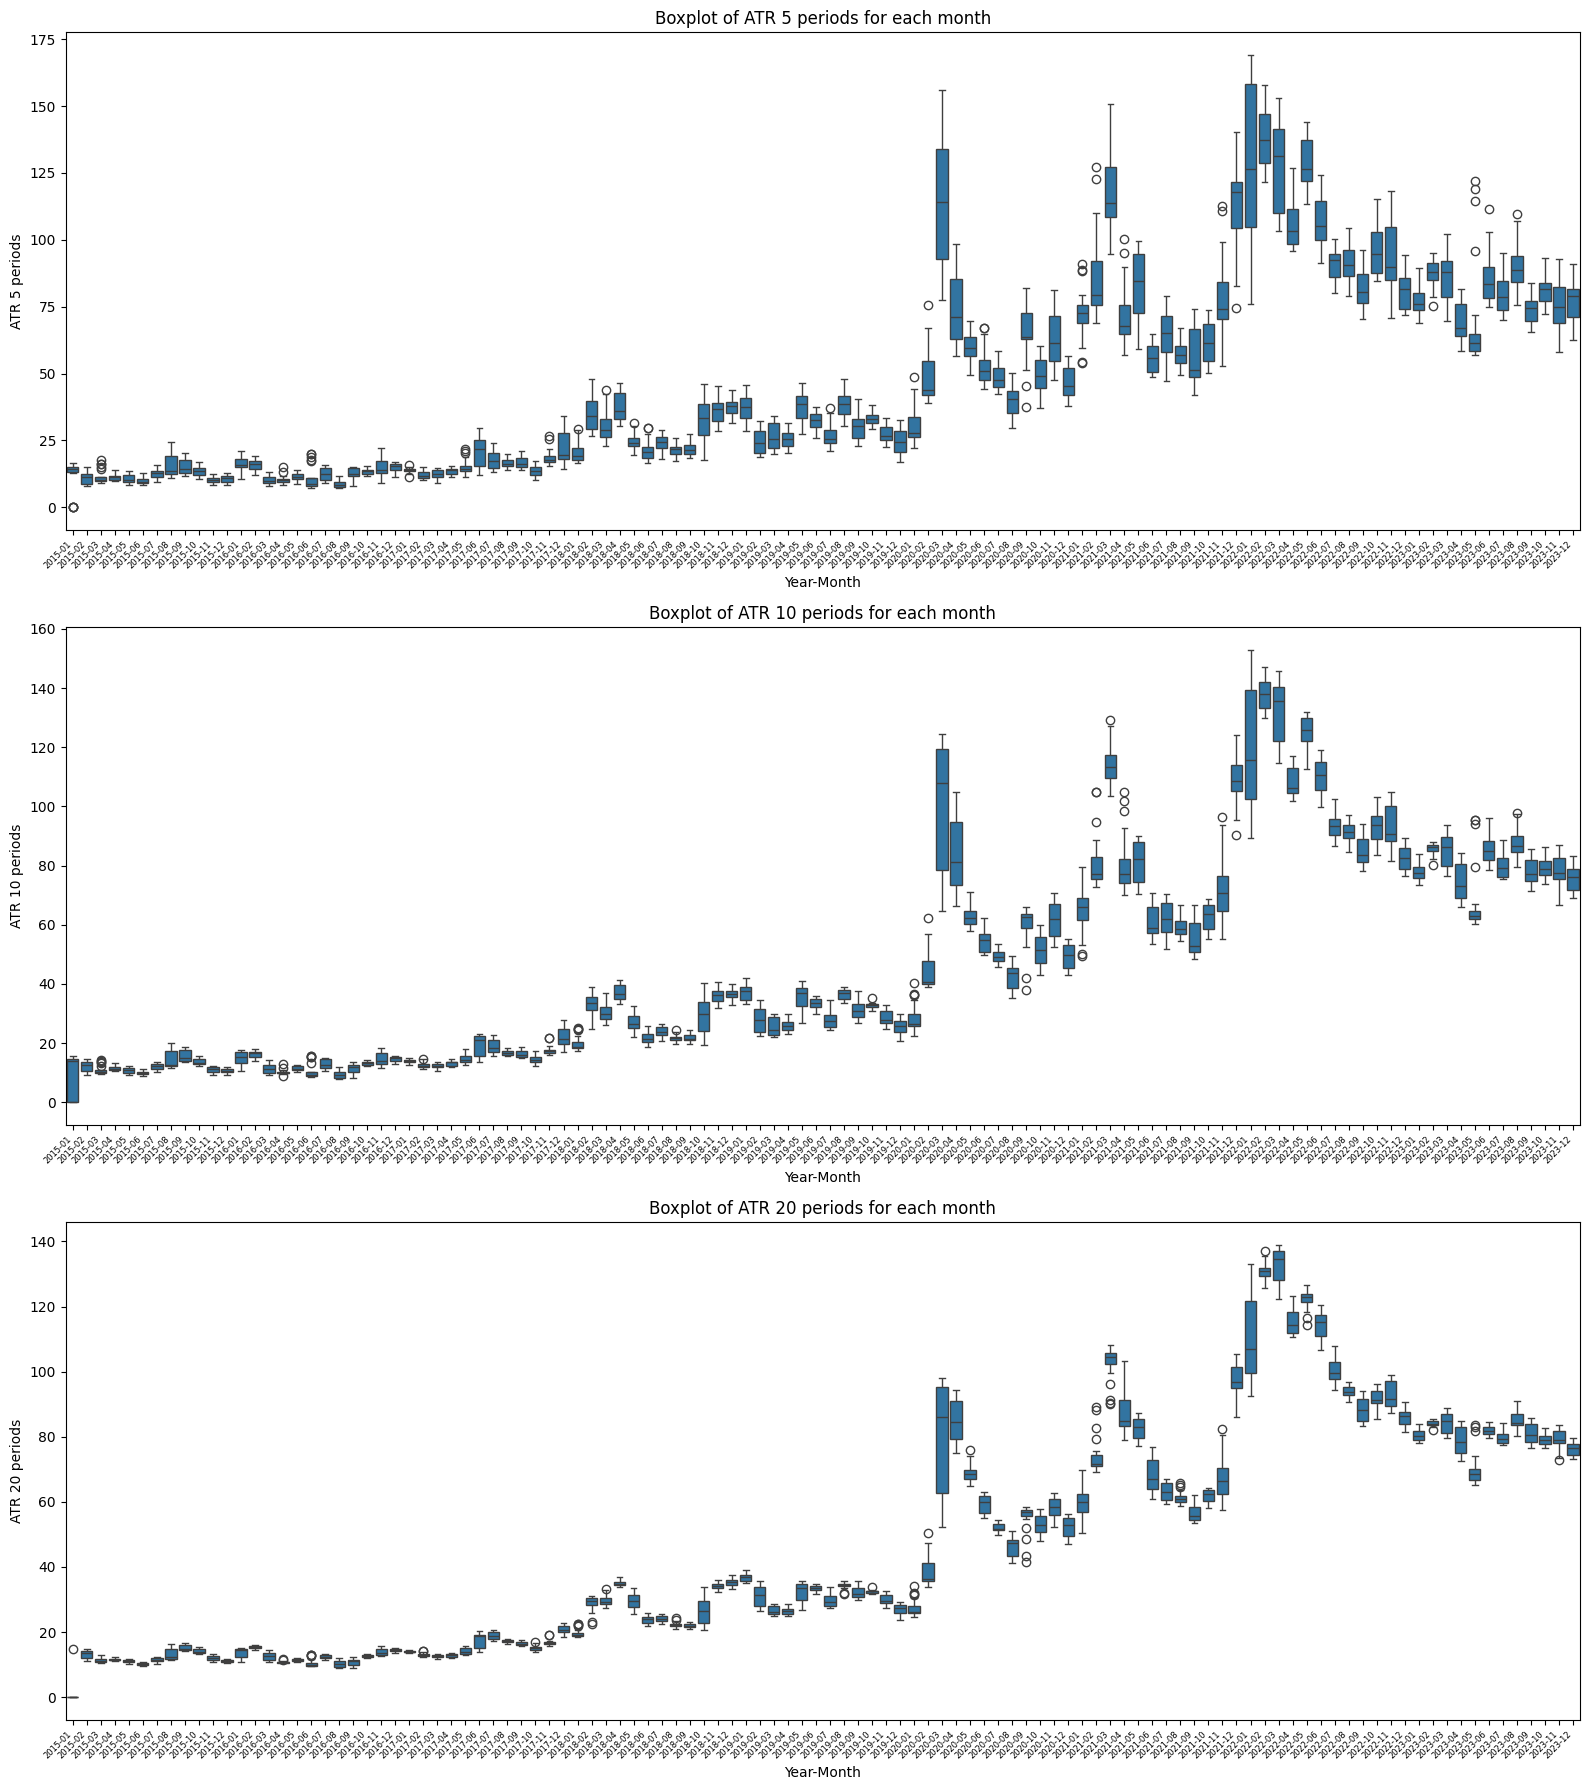

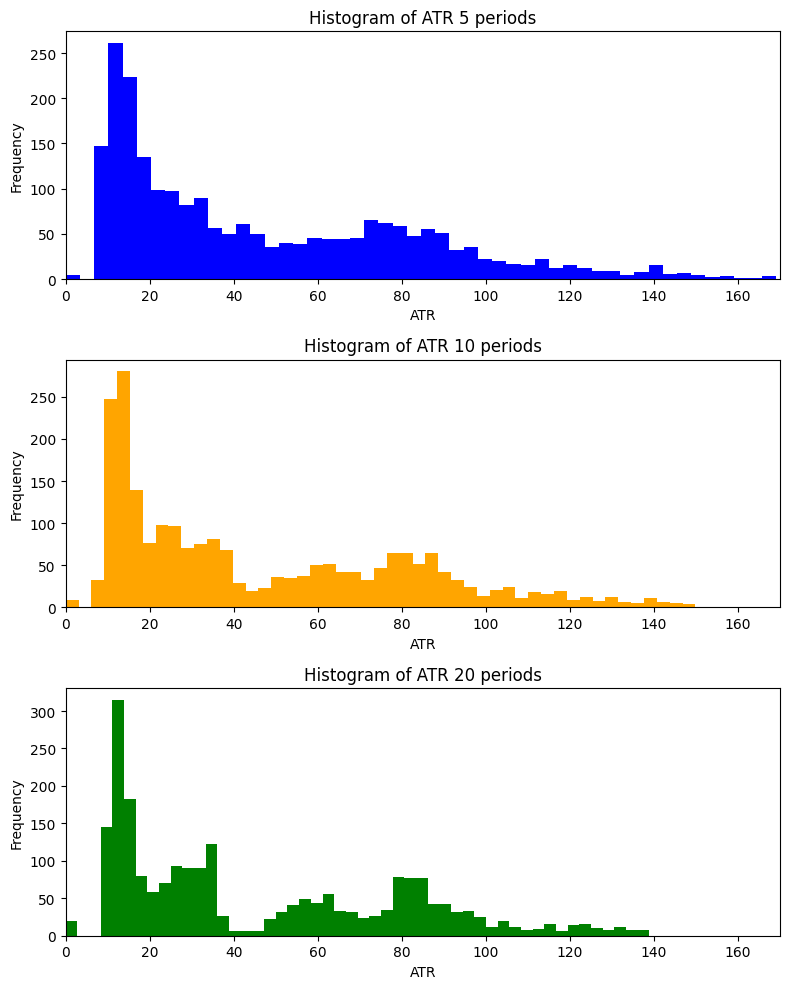

In [653]:
import ta

# Add new columns of Bolllinger Bands (5, 10, 20 periods) and the Average True Range (ATR) (5, 10, 20 periods)
data_ta = pd.DataFrame()
window_list = [5, 10, 20]
for i in range(len(window_list)):
    data_ta[f'BB_High_{window_list[i]}'] = data_spread['Close'].rolling(window_list[i]).mean() + 2 * data_spread['Close'].rolling(window_list[i]).std()
    data_ta[f'BB_Low_{window_list[i]}'] = data_spread['Close'].rolling(window_list[i]).mean() - 2 * data_spread['Close'].rolling(window_list[i]).std()
    data_ta[f'ATR_{window_list[i]}'] = ta.volatility.average_true_range(data_spread['High'], data_spread['Low'], data_spread['Close'], window=window_list[i])

# Plot 3 graph for Bollinger Bands and the Close price
color_list = ['blue', 'orange', 'green']
ax, fig = plt.subplots(3, 1, figsize=(16, 12))
for i in range(len(window_list)):
    fig[i].plot(data_spread['Close'], label='Close Price', linewidth=0.4, color='black')
    fig[i].plot(data_ta[f'BB_High_{window_list[i]}'], label=f'BB High {window_list[i]}', linewidth=0.2, color=color_list[i])
    fig[i].plot(data_ta[f'BB_Low_{window_list[i]}'], label=f'BB Low {window_list[i]}', linewidth=0.2, color=color_list[i])
    fig[i].fill_between(data_ta.index, data_ta[f'BB_Low_{window_list[i]}'], data_ta[f'BB_High_{window_list[i]}'], color=color_list[i], alpha=0.2)
    fig[i].set_title(f'Bollinger Bands {window_list[i]} periods')
    fig[i].set_xlabel('Date')
    fig[i].set_ylabel('Price')
    fig[i].legend()
plt.tight_layout()

# Boxplot for each month of the Average True Range (ATR)
data_ta['Year-Month'] = data_ta.index.strftime('%Y-%m')
print(data_ta)

fig, ax = plt.subplots(3, 1, figsize=(16, 18))
for i in range(len(window_list)):
    sns.boxplot(x='Year-Month', y=f'ATR_{window_list[i]}', data=data_ta, ax=ax[i])
    ax[i].set_title(f'Boxplot of ATR {window_list[i]} periods for each month')
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha='right', fontsize=6)
    ax[i].set_xlabel('Year-Month')
    ax[i].set_ylabel(f'ATR {window_list[i]} periods')
plt.tight_layout()

# 3 histograms for the Average True Range (ATR) for 5, 10, 20 periods
fig, fig = plt.subplots(3, 1, figsize=(8, 10))
for i in range(len(window_list)):
    fig[i].hist(data_ta[f'ATR_{window_list[i]}'], bins=50, color=color_list[i])
    fig[i].set_title(f'Histogram of ATR {window_list[i]} periods')
    fig[i].set_xlim(0, 170)
    fig[i].set_xlabel('ATR')
    fig[i].set_ylabel('Frequency')
plt.tight_layout()

data_ta = data_ta.drop(columns=['Year-Month'])

data_ta = data_preprocess_transform(data_ta.dropna())

[I 2024-04-28 12:51:11,866] A new study created in memory with name: no-name-1bfaee31-58a8-43ab-b121-9db2f776e026
[I 2024-04-28 12:51:11,980] Trial 0 finished with value: 0.09189891776018025 and parameters: {'learning_rate': 0.034885205571560766, 'num_leaves': 2, 'subsample': 0.8168241174631377, 'colsample_bytree': 0.8744019412693059, 'min_data_in_leaf': 10, 'gamma': 8}. Best is trial 0 with value: 0.09189891776018025.
[I 2024-04-28 12:51:12,213] Trial 1 finished with value: 0.09803694195883225 and parameters: {'learning_rate': 0.002489577954043502, 'num_leaves': 13, 'subsample': 0.5845554182812678, 'colsample_bytree': 0.5441699070870052, 'min_data_in_leaf': 14, 'gamma': 20}. Best is trial 0 with value: 0.09189891776018025.
[I 2024-04-28 12:51:12,432] Trial 2 finished with value: 0.10652240773291625 and parameters: {'learning_rate': 0.001018348745338606, 'num_leaves': 9, 'subsample': 0.9063104808260567, 'colsample_bytree': 0.8062630334146941, 'min_data_in_leaf': 15, 'gamma': 9}. Best i

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 1993, number of used features: 16
[LightGBM] [Info] Start training from score 0.165203
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7


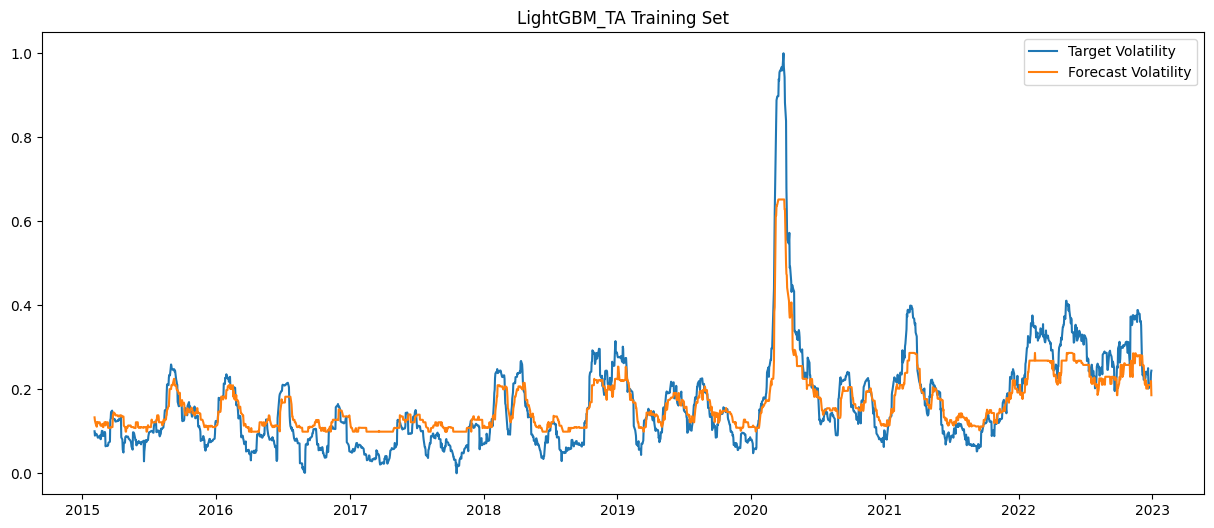

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7


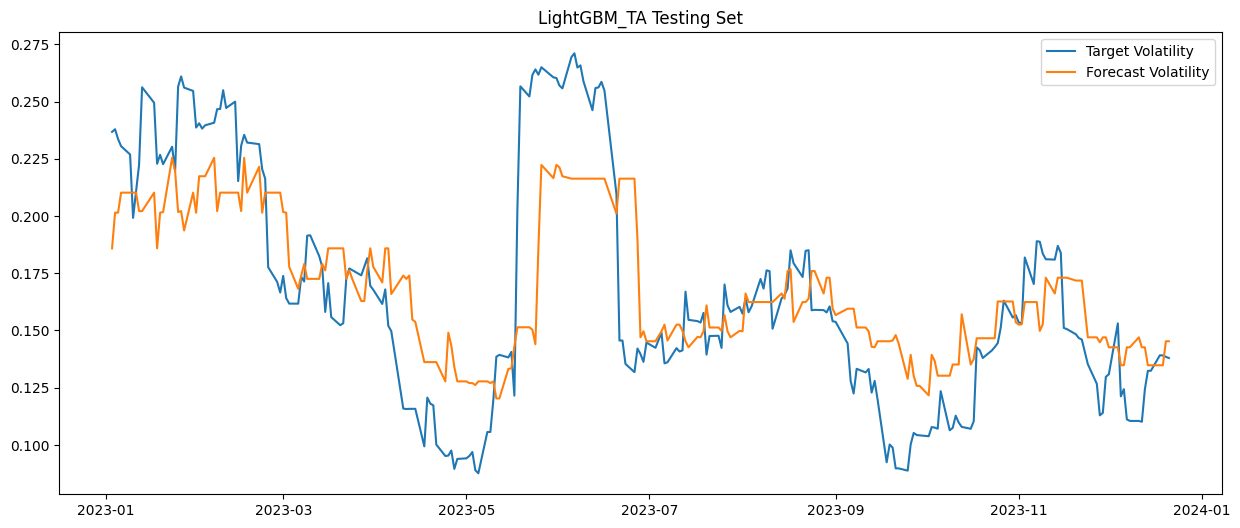

In [654]:
lightgbm_train_performance('TA', True, data_ta)

[I 2024-04-28 12:51:22,560] A new study created in memory with name: no-name-93135bf9-d0f5-43e0-bc84-1772f8a5b2c4


[I 2024-04-28 12:51:22,669] Trial 0 finished with value: 0.06787437666627757 and parameters: {'learning_rate': 0.034885205571560766, 'num_leaves': 2, 'subsample': 0.8168241174631377, 'colsample_bytree': 0.8744019412693059, 'min_data_in_leaf': 10, 'gamma': 8}. Best is trial 0 with value: 0.06787437666627757.
[I 2024-04-28 12:51:22,942] Trial 1 finished with value: 0.10209097165524576 and parameters: {'learning_rate': 0.002489577954043502, 'num_leaves': 13, 'subsample': 0.5845554182812678, 'colsample_bytree': 0.5441699070870052, 'min_data_in_leaf': 14, 'gamma': 20}. Best is trial 0 with value: 0.06787437666627757.
[I 2024-04-28 12:51:23,210] Trial 2 finished with value: 0.11087346697757443 and parameters: {'learning_rate': 0.001018348745338606, 'num_leaves': 9, 'subsample': 0.9063104808260567, 'colsample_bytree': 0.8062630334146941, 'min_data_in_leaf': 15, 'gamma': 9}. Best is trial 0 with value: 0.06787437666627757.
[I 2024-04-28 12:51:23,523] Trial 3 finished with value: 0.082474141815

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2543
[LightGBM] [Info] Number of data points in the train set: 1993, number of used features: 10
[LightGBM] [Info] Start training from score 0.165203
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


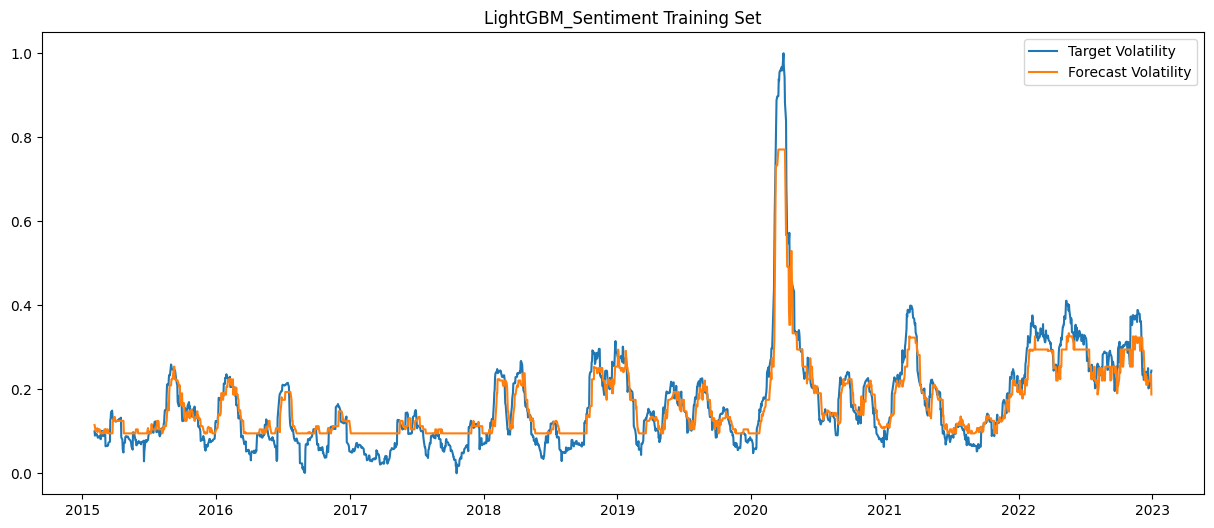

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


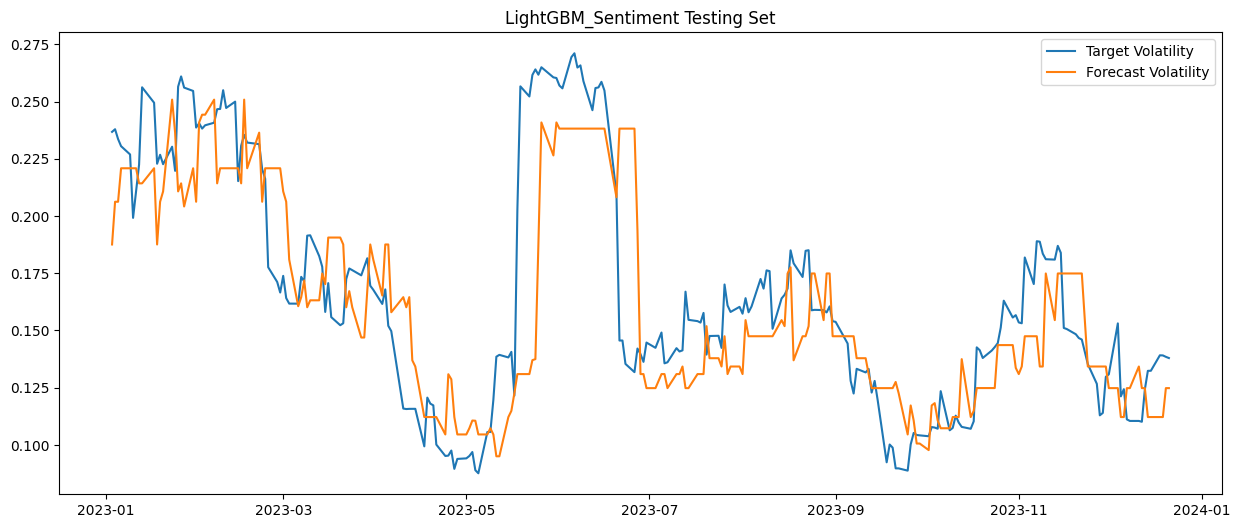

In [655]:
# Load the google trend and sentiment analysis data from the CSV file
data_sentiment = pd.read_csv('new_features_by_date.csv', index_col=0, parse_dates=True)
data_sentiment = data_preprocess_transform(data_sentiment.loc['2015-01-01':'2023-12-31'])
lightgbm_train_performance('Sentiment', True, data_sentiment)

[I 2024-04-28 12:51:30,316] A new study created in memory with name: no-name-961e7c09-a0bb-4a76-8bcd-efb168385803


[I 2024-04-28 12:51:30,632] Trial 0 finished with value: 0.08694776156314013 and parameters: {'learning_rate': 0.034885205571560766, 'num_leaves': 2, 'subsample': 0.8168241174631377, 'colsample_bytree': 0.8744019412693059, 'min_data_in_leaf': 10, 'gamma': 8}. Best is trial 0 with value: 0.08694776156314013.
[I 2024-04-28 12:51:31,459] Trial 1 finished with value: 0.09393672868974276 and parameters: {'learning_rate': 0.002489577954043502, 'num_leaves': 13, 'subsample': 0.5845554182812678, 'colsample_bytree': 0.5441699070870052, 'min_data_in_leaf': 14, 'gamma': 20}. Best is trial 0 with value: 0.08694776156314013.
[I 2024-04-28 12:51:33,150] Trial 2 finished with value: 0.10877997573329619 and parameters: {'learning_rate': 0.001018348745338606, 'num_leaves': 9, 'subsample': 0.9063104808260567, 'colsample_bytree': 0.8062630334146941, 'min_data_in_leaf': 15, 'gamma': 9}. Best is trial 0 with value: 0.08694776156314013.
[I 2024-04-28 12:51:34,589] Trial 3 finished with value: 0.082981855852

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26258
[LightGBM] [Info] Number of data points in the train set: 1978, number of used features: 103
[LightGBM] [Info] Start training from score 0.165768
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6


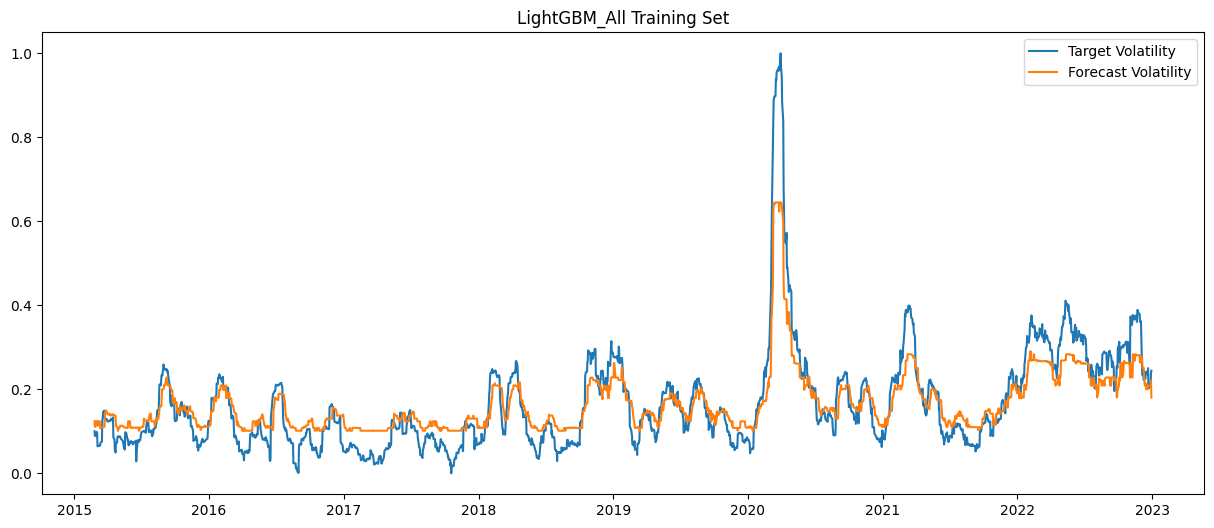

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6


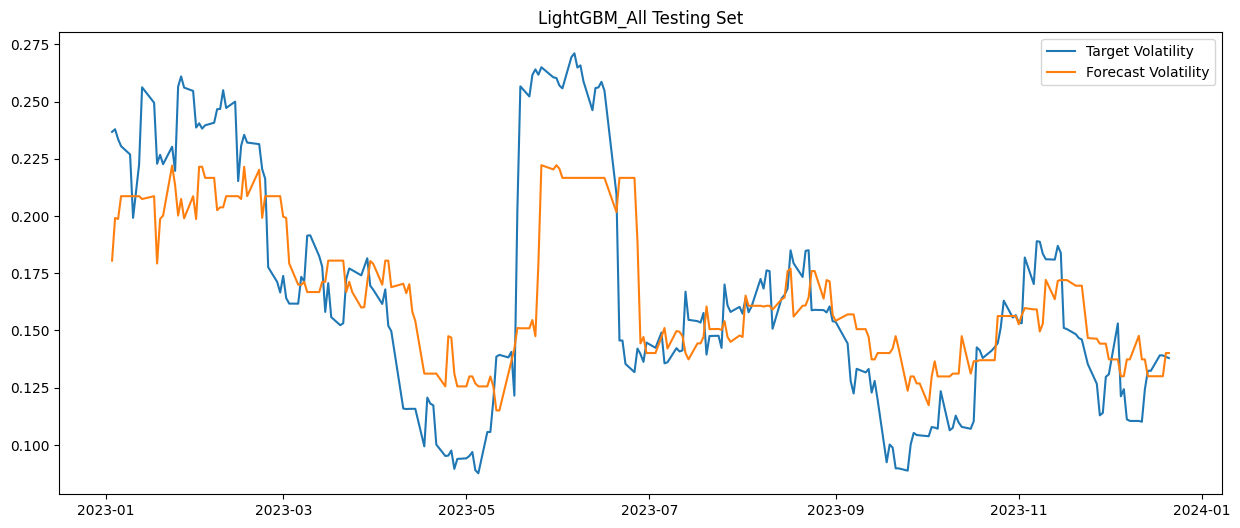

In [656]:
data_all_features = pd.concat([data_lag, data_VIX, data_spread_lag, data_ta, data_sentiment], axis=1)

lightgbm_train_performance('All', True, data_all_features)

[I 2024-04-28 12:52:09,374] A new study created in memory with name: no-name-0f56b8b1-ab61-4eda-a2e5-6efdea94809a


[I 2024-04-28 12:52:09,634] Trial 0 finished with value: 0.09266901962770928 and parameters: {'learning_rate': 0.034885205571560766, 'num_leaves': 2, 'subsample': 0.8168241174631377, 'colsample_bytree': 0.8744019412693059, 'min_data_in_leaf': 10, 'gamma': 8}. Best is trial 0 with value: 0.09266901962770928.
[I 2024-04-28 12:52:10,497] Trial 1 finished with value: 0.09758256965136063 and parameters: {'learning_rate': 0.002489577954043502, 'num_leaves': 13, 'subsample': 0.5845554182812678, 'colsample_bytree': 0.5441699070870052, 'min_data_in_leaf': 14, 'gamma': 20}. Best is trial 0 with value: 0.09266901962770928.
[I 2024-04-28 12:52:11,313] Trial 2 finished with value: 0.10669118454483247 and parameters: {'learning_rate': 0.001018348745338606, 'num_leaves': 9, 'subsample': 0.9063104808260567, 'colsample_bytree': 0.8062630334146941, 'min_data_in_leaf': 15, 'gamma': 9}. Best is trial 0 with value: 0.09266901962770928.
[I 2024-04-28 12:52:12,156] Trial 3 finished with value: 0.097299430270

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11730
[LightGBM] [Info] Number of data points in the train set: 1993, number of used features: 46
[LightGBM] [Info] Start training from score 0.165203
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16


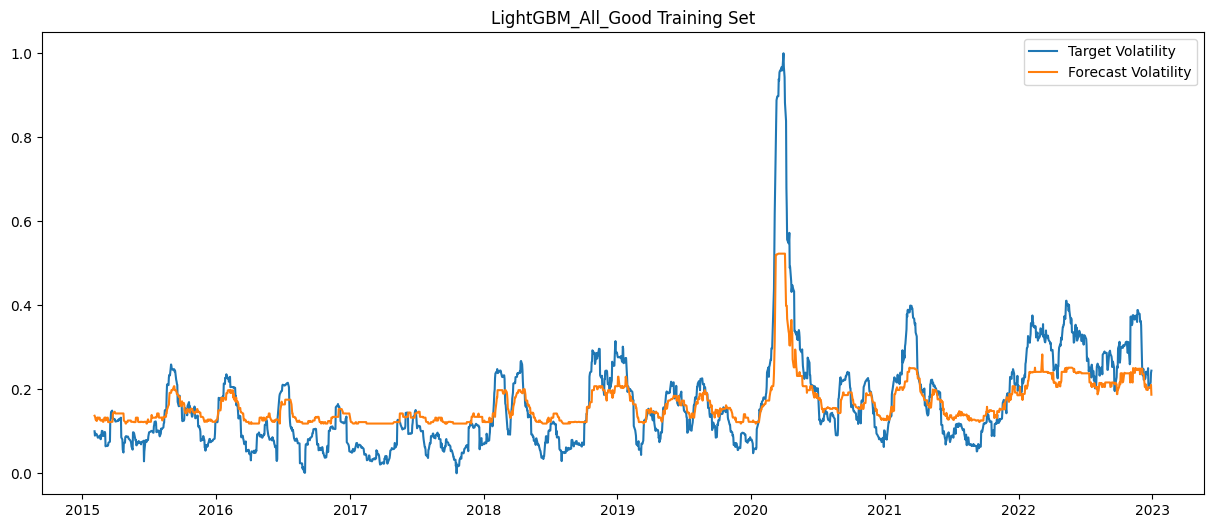

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16


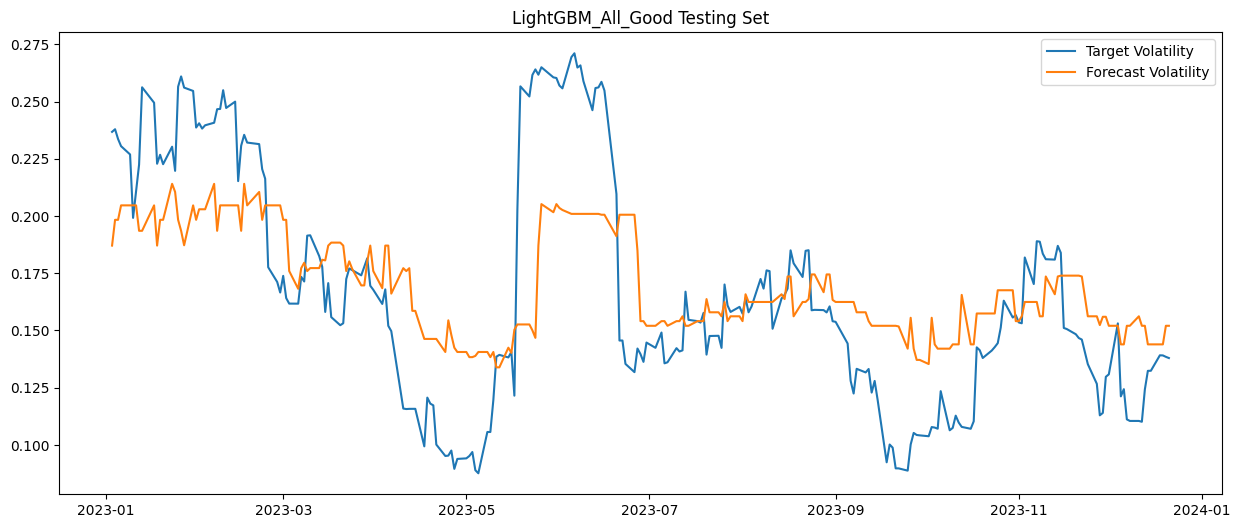

In [657]:
data_good_features = pd.concat([data_spread_lag, data_ta], axis=1)

lightgbm_train_performance('All_Good', True, data_good_features)

### Model Performance Analysis
1. Performance Matrix
2. Feature Importance
3. Learning Curve of Trials

In [658]:
# Print the model results ordered by the R2 score
model_result.sort_values(by='R2', ascending=False)

,Name,Stydy,Model,RMSE,R2,RMSPE
3,LightGBM_SOX Spread,<optuna.study.study.Study object at 0x00000175...,LGBMRegressor(colsample_bytree=0.9298743628767...,0.030089,0.640333,0.193286
2,LightGBM_VIX Log Value,<optuna.study.study.Study object at 0x00000175...,LGBMRegressor(colsample_bytree=0.9913766886782...,0.030653,0.626729,0.185621
0,LightGBM_Baseline,<optuna.study.study.Study object at 0x00000175...,LGBMRegressor(colsample_bytree=0.8744019412693...,0.030809,0.622914,0.185325
1,LightGBM_SOX RV Lag,<optuna.study.study.Study object at 0x00000175...,LGBMRegressor(colsample_bytree=0.9293093903505...,0.030929,0.619977,0.189553
5,LightGBM_Sentiment,<optuna.study.study.Study object at 0x00000175...,LGBMRegressor(colsample_bytree=0.8744019412693...,0.031064,0.616647,0.185858
6,LightGBM_All,<optuna.study.study.Study object at 0x00000175...,LGBMRegressor(colsample_bytree=0.8376700843544...,0.031419,0.607836,0.205911
4,LightGBM_TA,<optuna.study.study.Study object at 0x00000175...,LGBMRegressor(colsample_bytree=0.8217150545966...,0.032041,0.592165,0.214751
7,LightGBM_All_Good,<optuna.study.study.Study object at 0x00000175...,LGBMRegressor(colsample_bytree=0.7814210621485...,0.036106,0.482093,0.249194


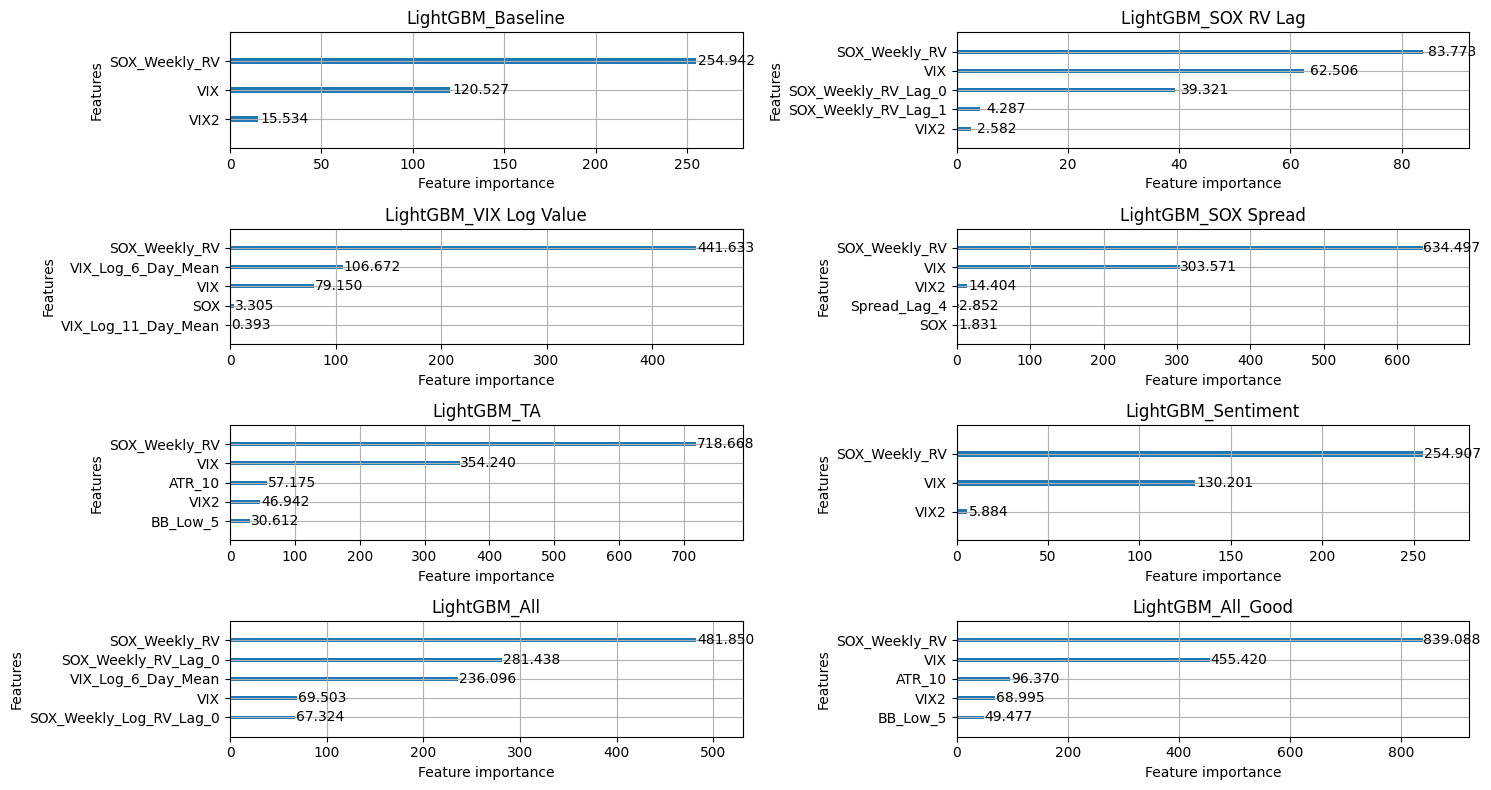

In [659]:
# Plot the feature importance for each model
fig, ax = plt.subplots(4, 2, figsize=(15, 8))
for i in range(4):
    for j in range(2):
        if i*2+j < len(model_result):
            lgb.plot_importance(model_result['Model'][i*2+j], ax=ax[i, j], importance_type='gain', max_num_features=5)
            ax[i, j].set_title(model_result['Name'][i*2+j])
plt.tight_layout()

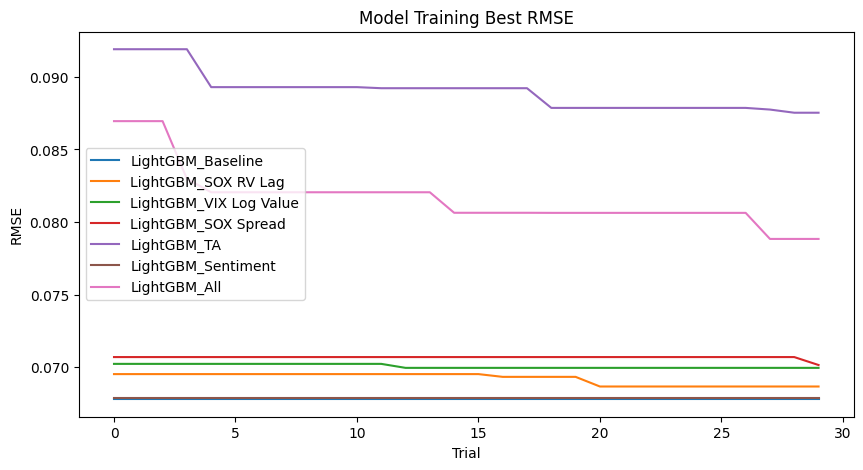

In [660]:
# Plot the min RMSE of each trial for each model
plt.figure(figsize=(10, 5))
for i in range(len(model_result)-1):
    # plot the best value for each trail
    plt.plot(model_result['Stydy'][i].trials_dataframe()['value'].cummin(), label=model_result['Name'][i])
plt.xlabel('Trial')
plt.ylabel('RMSE')
# plt.ylim(0.075, 0.1)
plt.title('Model Training Best RMSE')
plt.legend()
plt.show()